In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from tensorflow.keras.regularizers import l2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

from spektral.data.loaders import SingleLoader, DisjointLoader, BatchLoader
from spektral.layers import GATConv, DiffusionConv, GCNConv
from spektral.transforms import LayerPreprocess

from tools.extract import generateNNdataMultiple
from tools.constants import airports_top10, airports_top25, airports_top50
from tools.adjacency import distance_adjacency, throughput_adjacency

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from tools.extract import generalFilterAirport, filterAirports
from tqdm import tqdm

pd.set_option("display.max_columns", None)



In [2]:
# check GPR settings

# tf.config.list_physical_devices("GPU")

In [3]:
# removing istanbul airport as it opened in mid-2019
airports = list(filter(lambda x: x != "LTFM", airports_top50))

n_nodes = n_airports = len(airports)

start=datetime(2018, 1, 1)
end=datetime(2019, 12, 31)

timeinterval = 30


## Load Data

In [4]:
data_dict = generateNNdataMultiple(
    airports,
    timeinterval,
    GNNFormat=True,
    start=start,
    end=end,
    forceRegenerateData=False,
)


100%|██████████| 49/49 [00:01<00:00, 30.48it/s]


In [5]:
# randomly split train, test

# np.random.seed(42)
dates = data_dict["EGLL"]["X"].date.sort_values().unique()
# np.random.shuffle(dates)

idx_split = int(len(dates) * 0.80)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]


In [6]:
X_all = pd.concat([d["X"] for ap, d in data_dict.items()]).drop(
    ["date", "timeslot"], axis=1
)
Y_all = pd.concat([d["Y"] for ap, d in data_dict.items()])

scaler = StandardScaler()
scaler.fit(pd.concat([X_all, Y_all], axis=1))


StandardScaler()

In [7]:
X_train_list = []
Y_train_list = []
X_test_list = []
Y_test_list = []


for airport in airports:
    xy = pd.concat([data_dict[airport]["X"], data_dict[airport]["Y"]], axis=1)
    xy_train = xy.query("date in @train_dates")
    xy_test = xy.query("date in @test_dates")

    # train: size T x F
    x_train = xy_train.drop(columns=["timeslot", "date"])
    y_train = xy_train[["arrivalsArrivalDelay", "departuresDepartureDelay"]]
    X_train_list.append(scaler.transform(x_train))
    Y_train_list.append(y_train)

    # test: size T x F
    x_test = xy_test.drop(columns=["timeslot", "date"])
    y_test = xy_test[["arrivalsArrivalDelay", "departuresDepartureDelay"]]
    X_test_list.append(scaler.transform(x_test))
    Y_test_list.append(y_test)

X_train = np.stack(X_train_list)
Y_train = np.stack(Y_train_list)
X_test = np.stack(X_test_list)
Y_test = np.stack(Y_test_list)

# N x T x F
X_train = np.swapaxes(X_train, 0, 1).astype(np.float16)
Y_train = np.swapaxes(Y_train, 0, 1).astype(np.float16)
X_test = np.swapaxes(X_test, 0, 1).astype(np.float16)
Y_test = np.swapaxes(Y_test, 0, 1).astype(np.float16)

print(f"T x N x F: X_train = {X_train.shape} | Y_train = {Y_train.shape}")
print(f"T x N x F: X_test = {X_test.shape} | Y_test = {Y_test.shape}")


T x N x F: X_train = (9312, 49, 11) | Y_train = (9312, 49, 2)
T x N x F: X_test = (2352, 49, 11) | Y_test = (2352, 49, 2)


## Generate Adjacency Matrices

In [8]:
buffer = []

for airport in tqdm(airports):
    # generate filtered data
    df_ap = generalFilterAirport(start, end, airport)
    df_ap = filterAirports(df_ap, airports)
    df_ap = df_ap[["ADEP", "ADES", "FiledOBT", "FiledAT"]]

    buffer.append(df_ap)

df_net = pd.concat(buffer).assign(date=lambda d: d.FiledOBT.dt.date.astype(str))


100%|██████████| 49/49 [00:44<00:00,  1.09it/s]


In [9]:
throughput_adj_train = throughput_adjacency(
    df_net.query("date in @train_dates").drop(columns=["date"]),
    airports,
    start,
    end,
    timeinterval,
    train_dates,
)

throughput_adj_test = throughput_adjacency(
    df_net.query("date in @test_dates").drop(columns=["date"]),
    airports,
    start,
    end,
    timeinterval,
    test_dates,
)

print(throughput_adj_train.shape, throughput_adj_test.shape)


(9312, 49, 49) (2352, 49, 49)


In [10]:
distance_adj = distance_adjacency(airports, threshold=400)

In [11]:
A_train = distance_adj * 0.4 + (1 - 0.4) * throughput_adj_train
A_test = distance_adj * 0.4 + (1 - 0.4) * throughput_adj_test

# reduce precision to fit on GPU
A_train = A_train.astype(np.float16)
A_test = A_test.astype(np.float16)


#### Custom new TF dataset

In [12]:
def createDataset(
    Features: np.ndarray,
    Adjacencies: np.ndarray,
    Targets: np.ndarray,
    lookback: int,
    lookahead: int,
    batch_size: int = 64,
):

    # make windows
    idx = 0
    F_samples = []
    A_samples = []
    Y_samples = []

    while idx + lookback + lookahead < len(Features):

        # Features
        F_sample = Features[idx : idx + lookback, :, :]
        F_samples.append(F_sample)

        # Adjacencies
        A_sample = Adjacencies[idx : idx + lookback, :, :]
        A_samples.append(A_sample)

        # make labels with multi-horizon
        Y_sample = Targets[idx + lookback : idx + lookback + lookahead, :, :]
        Y_samples.append(Y_sample)

        idx += 1

    features = np.array(F_samples)
    adjacencies = np.array(A_samples)
    labels = np.array(Y_samples)

    # Ensure only complete batches are made (remove incomplete ones)
    batchCutoff = features.shape[0] - (features.shape[0] % batch_size)

    features, adjacencies, labels = (
        features[:batchCutoff, :, :, :],
        adjacencies[:batchCutoff, :, :, :],
        labels[:batchCutoff, :, :, :],
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        ((features, adjacencies), labels)
    ).batch(batch_size)

    ds = tf.data.Dataset.from_generator(lambda: np.arange(100), output_signature=tf.TensorSpec(shape=(), dtype=tf.int32))

    return dataset



In [13]:
# Run settings

batch_size = 64
epochs = 100
patience = 5
lookback = 8
lookahead = 6

In [14]:

train_dataset = createDataset(
    X_train, A_train, Y_train, lookback, lookahead, batch_size=batch_size
)
test_dataset = createDataset(
    X_test, A_test, Y_test, lookback, lookahead, batch_size=batch_size
)

print(train_dataset)
print(test_dataset)


2022-02-15 15:06:11.990571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 15:06:12.019442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 15:06:12.019847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 15:06:12.020859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

<BatchDataset shapes: (((None, 8, 49, 11), (None, 8, 49, 49)), (None, 6, 49, 2)), types: ((tf.float16, tf.float16), tf.float16)>
<BatchDataset shapes: (((None, 8, 49, 11), (None, 8, 49, 49)), (None, 6, 49, 2)), types: ((tf.float16, tf.float16), tf.float16)>


## GNN Model

In [15]:
l2_reg = 2.5e-4
channels = 10
attn_heads = 10
lstm_units = 60
num_labels = 2
nFeatures = X_train.shape[2]

In [16]:
x_in = layers.Input(
    shape=(lookback, n_nodes, nFeatures), batch_size=batch_size, name="Features"
)
a_in = layers.Input(
    shape=(lookback, n_nodes, n_nodes), batch_size=batch_size, name="Adjacencies"
)

x_inn = tf.reshape(x_in, (batch_size * lookback, n_airports, nFeatures))
a_inn = tf.reshape(a_in, (batch_size * lookback, n_airports, n_airports))

gatout = GATConv(
    channels=channels,
    attn_heads=attn_heads,
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
    name=f"GAT",
)([x_inn, a_inn])
print(gatout.shape)

reshape1 = tf.reshape(gatout, (batch_size, lookback, n_airports, attn_heads * channels))
print(reshape1.shape)

reshape1 = tf.transpose(reshape1, [0, 2, 1, 3])
print(reshape1.shape)

reshape1 = tf.reshape(
    reshape1, (batch_size * n_airports, lookback, attn_heads * channels)
)
print(reshape1.shape)


lstm1 = layers.LSTM(lstm_units, return_sequences=True, name="LSTM1")(reshape1)
lstm2 = layers.LSTM(lstm_units, return_sequences=False, name="LSTM2")(lstm1)
print(lstm2.shape)

dense1 = layers.Dense(lstm_units, name="Dense1")(lstm2)
print(dense1.shape)

dense2 = layers.Dense(num_labels * lookahead, name="DenseFinal")(dense1)
print(dense2.shape)

output = tf.reshape(
    dense2, (batch_size, n_nodes, lookahead, num_labels), name="ReshapeFinal"
)
# output = tf.reshape(dense2, (n_nodes, batch_size, lookahead, num_labels), name="ReshapeFinal")
print(output.shape)

output = tf.transpose(output, [0, 2, 1, 3], name="Re-orderToOutput")
print(output.shape)


(512, 49, 100)
(64, 8, 49, 100)
(64, 49, 8, 100)
(3136, 8, 100)
(3136, 60)
(3136, 60)
(3136, 12)
(64, 49, 6, 2)
(64, 6, 49, 2)


In [17]:
model = keras.Model(inputs=[x_in, a_in], outputs=output, name="DST-GAT")

optimizer = Adam()

model.compile(optimizer=optimizer, loss="mse")

model.summary()


Model: "DST-GAT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features (InputLayer)          [(64, 8, 49, 11)]    0           []                               
                                                                                                  
 Adjacencies (InputLayer)       [(64, 8, 49, 49)]    0           []                               
                                                                                                  
 tf.reshape (TFOpLambda)        (512, 49, 11)        0           ['Features[0][0]']               
                                                                                                  
 tf.reshape_1 (TFOpLambda)      (512, 49, 49)        0           ['Adjacencies[0][0]']            
                                                                                            

In [18]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=patience)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[es],
    shuffle=False,
)


Epoch 1/100


2022-02-15 15:06:17.416283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605


145/145 [==============================] - 42s 273ms/step - loss: 63.6824 - val_loss: 53.4833
Epoch 2/100
145/145 [==============================] - 39s 271ms/step - loss: 56.5372 - val_loss: 50.5943
Epoch 3/100
145/145 [==============================] - 39s 272ms/step - loss: 54.9366 - val_loss: 49.7760
Epoch 4/100
145/145 [==============================] - 40s 274ms/step - loss: 54.2271 - val_loss: 49.4091
Epoch 5/100
145/145 [==============================] - 39s 272ms/step - loss: 53.7444 - val_loss: 49.0865
Epoch 6/100
145/145 [==============================] - 41s 283ms/step - loss: 53.3694 - val_loss: 48.8643
Epoch 7/100
145/145 [==============================] - 39s 271ms/step - loss: 53.0517 - val_loss: 48.6882
Epoch 8/100
145/145 [==============================] - 40s 273ms/step - loss: 52.8165 - val_loss: 48.5839
Epoch 9/100
145/145 [==============================] - 39s 272ms/step - loss: 52.5777 - val_loss: 48.5123
Epoch 10/100
145/145 [==============================] - 40

# Analysis


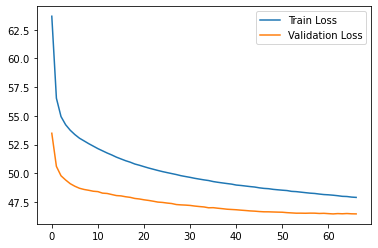

In [19]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


In [20]:
Y_pred = model.predict(test_dataset)


## Generate output dataset

In [21]:
buffer = []

for i, airport in enumerate(airports):
    xy = pd.concat([data_dict[airport]["X"], data_dict[airport]["Y"]], axis=1)
    xy_test = xy.query("date in @test_dates").iloc[lookback:]

    # Test delay metric, column represent lookahead time
    arr_delay = Y_test[lookback:, i, 0]
    n_row = len(arr_delay)-lookahead
    arr_delays = np.empty((n_row, lookahead))
    for k in range(lookahead):
        arr_delays[:, k] = arr_delay[k:k+n_row]

    dep_delay = Y_test[lookback:, i, 1]
    n_row = len(dep_delay)-lookahead
    dep_delays = np.empty((n_row, lookahead))
    for k in range(lookahead):
        dep_delays[:, k] = dep_delay[k:k+n_row]

    airport_delays = pd.concat(
        [
            pd.DataFrame().assign(time=xy_test['timeslot'].values),

            pd.DataFrame(
                arr_delays.round().astype(int),
                columns=[f"arr_{30*n}m" for n in range(1, lookahead+1)],
            ),

            pd.DataFrame(
                dep_delays.round().astype(int),
                columns=[f"dep_{30*n}m" for n in range(1, lookahead+1)],
            ),

            pd.DataFrame(
                Y_pred[:, :, i, 0].round().astype(int),
                columns=[f"arr_est_{30*n}m" for n in range(1, lookahead+1)],
            ),
            pd.DataFrame(
                Y_pred[:, :, i, 1].round().astype(int),
                columns=[f"dep_est_{30*n}m" for n in range(1, lookahead+1)],
            ),
        ],
        axis=1,
    ).dropna().assign(airport=airport)

    buffer.append(airport_delays)

results = pd.concat(buffer, ignore_index=True)

In [22]:
# results.to_csv("data/network_delay_gnn_results.csv", index=False)

In [23]:
df = results.query('airport == "EGLL"')

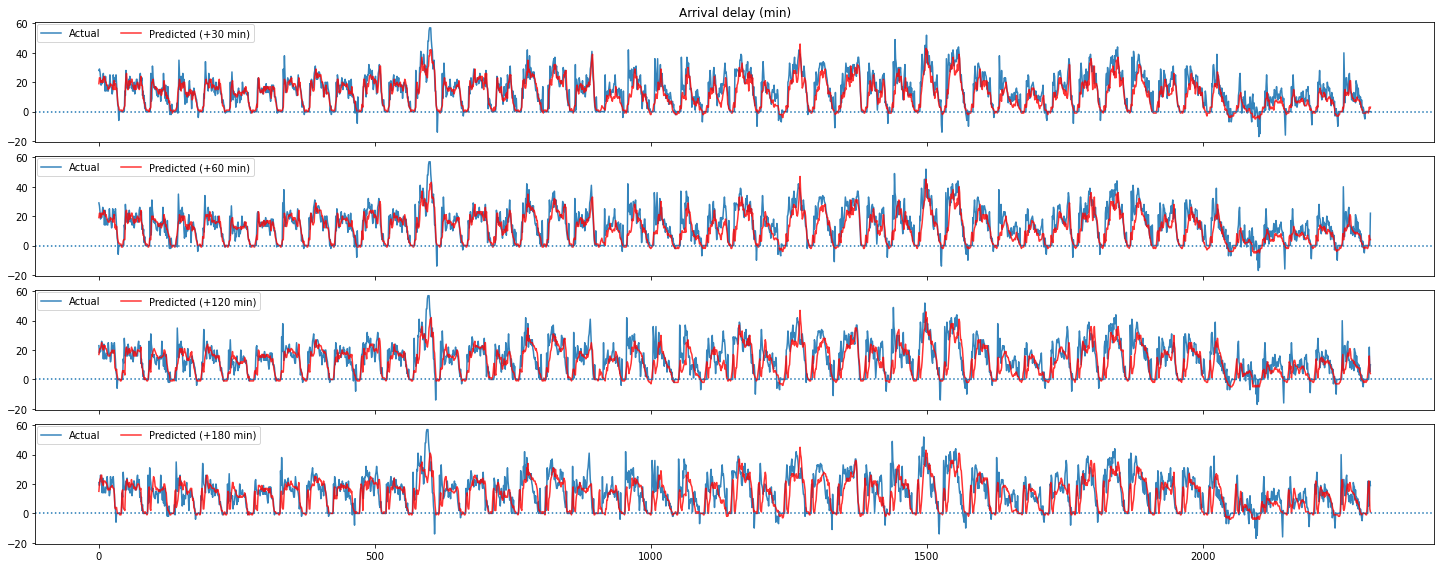

In [24]:

fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.arr_30m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Arrival delay (min)")


ax = axes[1]
ax.plot(df.arr_60m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.arr_120m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.arr_180m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

plt.tight_layout()



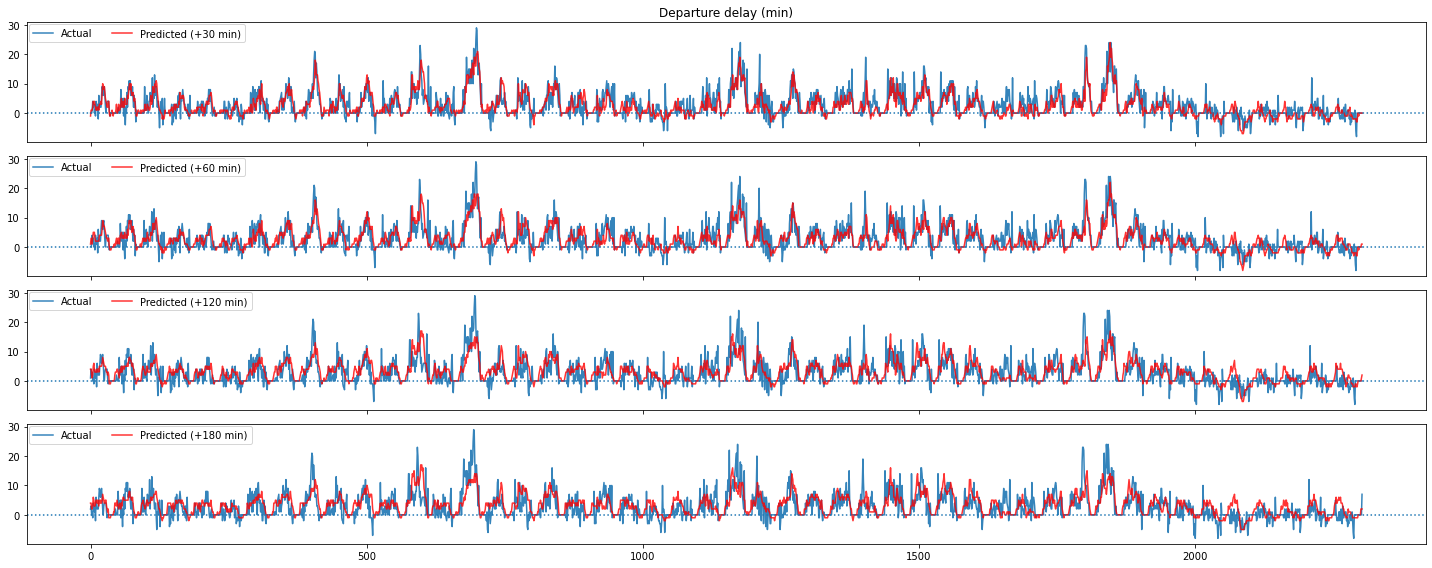

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(20, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.dep_30m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Departure delay (min)")


ax = axes[1]
ax.plot(df.dep_60m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.dep_120m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.dep_180m, alpha=0.9, label="Actual")
ax.plot(df.dep_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

plt.tight_layout()